<a href="https://colab.research.google.com/github/kznts9v-1lya/formal-lang-course/blob/task5-rpq-research/researches/rpq_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Автор: [kznts9v_1lya](https://github.com/kznts9v-1lya)

---

# Экспериментальное исследование производительности CPU и GPU версий алгоритма Regular Path Quering

## Введение

Имеется **размеченный граф** $G$, задающий регулярный язык $L_G$.

Имеется **регулярное выражение** $Q$, задающее регулярный язык ограничений $L_Q$.

Задача $Regular Path Quering$ решает проблему достижимости между всеми парами вершин с регулярными ограничениями через тензорное произведение. Ограничения представляются в виде пар достижимых вершин графа, представляющего $L_G\cap L_Q$.

$RPQ = \{(v_i, v_j)|\exists\pi:w(v_i\pi v_j)\in L, v_i\in V_S, v_j\in V_F\}$, где $L = L_G\cap L_Q$

Известно свойство, что регулярные языки замкнуты относительно пересечения и по ним можно построить конечный автомат, допускающий эти языки. Именно поэтому $RPQ$ строит язык пересечения, задаваемый пересечением двух конечных автоматов $КА_{G}$ и $КА_{Q}$, допускающих $L_G$ и $L_Q$ соответсвенно, --- также конечным автоматом $КА_{I}$.

Обратимся к определению, $КА_3 = КА_1\cap КА_2 = (S^{1}\times S^{2}, \Delta^{3}, S^{1}_S\times S^{2}_S, S^{1}_F\times S^{2}_F)$, где функция переходов задаётся как
$\Delta^{3}: (v_i, v_j)\times l_{abel}\rightarrow (u_i, u_j)$

$
\begin{cases}
v_i\in S^{1}\times l\rightarrow u_i\in S^{1}\in\Delta^{1} \\
v_j\in S^{2}\times l\rightarrow u_j\in S^{2}\in\Delta^{2}
\end{cases}$

Для нахождения функции переходов $\Delta^{I}$ используется алгоритм, основанный на тензорном произведении булевых матриц смежности конечных автоматов $КА_{G}$ и $КА_{Q}$, также известном как произведение Кронекера, и последующем построении транизитивного замыкания.

В данной работе будет экспериментально исследована скорость работы описанного алгоритма решения проблемы $RPQ$, реализованный в двух вариантах $-$ на $CPU$ и $GPU$.

---

## Постановка цели исследования

Для достижения поставленной цели $-$ экспериментального исследования скорости работы описанного алгоритма решения проблемы $RPQ$ $-$ необходимо выполнить следующие подзадачи:

- Используя разряженные матрицы [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html) реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение с использованием $CPU$;
- Используя библиотеку [pyCuBool](https://pypi.org/project/pycubool/) реализовать алгоритм пересечения двух конечных автоматов через тензорное произведение с использованием технологии $CUDA$ для $GPU$;
- Сформировать датасет, необходимый для проведения экспериментов;
- Произвести сравнительный анализ производительности версий алгоритма.

---

## Подготовка окружения

In [1]:
# Развёртывание репозитория
# !git clone https://github.com/kznts9v-1lya/formal-lang-course.git &> /dev/null
# !cd formal-lang-course && git checkout task5-rpq-research &> /dev/null

In [2]:
# Установка внешних зависимостей
# !pip install -r formal-lang-course/requirements.txt &> /dev/null
!pip install pycubool &> /dev/null
!pip install pandas &> /dev/null
!pip install matplotlib &> /dev/null
!pip install seaborn &> /dev/null

In [3]:
# Инициализация директории в окружении
# import sys
# sys.path.insert(1, 'formal-lang-course')

---

## Описание данных исследования

### Графы

В качестве $G$ использовуются все графы из [RDF](https://jetbrains-research.github.io/CFPQ_Data/dataset/RDF.html) датасета, за исключением **taxonomy** и **taxonomy_hierarchy** из-за их исключительных размеров.

In [4]:
# Названия использующихся графов

GRAPH_NAMES = (
    "skos",
    "generations",
#     "travel",
#     "univ_bench",
#     "atom_primitive",
#     "biomedical_mesure_primitive",
#     "foaf",
#     "people_pets",
#     "funding",
#     "wine",
#     "pizza",
#     "core",
#     "pathways",
#     "enzyme",
#     "go_hierarchy",
#     "eclass_514en",
#     "go",
#     "geospecies",
)

In [5]:
# Объекты использующихся графов

from project.graph_tools import get_from_dataset

GRAPHS = []

for graph_name in GRAPH_NAMES:
    GRAPHS.append(get_from_dataset(graph_name))

In [36]:
# Информация об использующихся графах

import pandas as pd

node_numbers = []
edge_numbers = []
edge_labels_numbers = []

for graph in GRAPHS:
    node_number, edge_number = graph.description.nodes, graph.description.edges
    node_numbers.append(node_number)
    edge_numbers.append(edge_number)
    edge_labels_number = len(graph.description.edge_labels)
    edge_labels_numbers.append(edge_labels_number)

graph_descriptions_df = pd.DataFrame(
    {
        "Node number": node_numbers,
        "Edge number": edge_numbers,
        "Labels number": edge_labels_numbers
    },
    index=GRAPH_NAMES
)

graph_descriptions_df

,Node number,Edge number,Labels number
skos,144,252,21
generations,129,273,17


### Запросы

Запросы представляют из себя регулярные выражения. В них используются все общепринятые конструкции регулярных выражений (замыкание, конкатенация, альтернатива).

Ниже приведён набор из четырёх используемых запросов.
- $(L_0 | L_1)^* L_2$
- $L_0 | L_2 | L_1^*$
- $L_0 L_1 L_2 (L_3 | L_1)^*$
- $(L_0 | L_3)^* | (L_1 | L_2)^*$

#### Генераторы запросов


Функции ниже отвечают за генерацию запросов как регулярных выражений.

In [7]:
# Создание генераторов регулярных выражений --- запросов к графам

from pyformlang.regular_expression.regex_objects import Symbol


def _regex_from_label(label):
    regex = Regex("")
    regex.head = Symbol(str(label))

    return regex


# (L0 | L1)* L2
def query_one(labels):
    """
    (L0 | L1)* L2
    """

    label_regex_0 = None
    label_regex_1 = None
    label_regex_2 = None

    labels_num = len(labels)
    if labels_num >= 3:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
    elif labels_num == 2:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = label_regex_1
    elif labels_num == 1:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = label_regex_0
        label_regex_2 = label_regex_1

    return label_regex_0.union(label_regex_1).kleene_star().concatenate(label_regex_2)


# L0 | L2 | L1*
def query_two(labels):
    """
    L0 | L2 | L1*
    """

    label_regex_0 = None
    label_regex_1 = None
    label_regex_2 = None
    
    labels_num = len(labels)
    if labels_num >= 3:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
    elif labels_num == 2:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = label_regex_1
    elif labels_num == 1:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = label_regex_0
        label_regex_2 = label_regex_1

    return label_regex_0.union(label_regex_2).union(label_regex_1.kleene_star())


# L0 L1 L2 (L3 | L1)*
def query_three(labels):
    """
    L0 L1 L2 (L3 | L1)*
    """

    label_regex_0 = None
    label_regex_1 = None
    label_regex_2 = None
    label_regex_3 = None

    labels_num = len(labels)
    if labels_num >= 4:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
        label_regex_3 = _regex_from_label(labels[3])
    if labels_num == 3:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
        label_regex_3 = label_regex_2
    elif labels_num == 2:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = label_regex_1
        label_regex_3 = label_regex_2
    elif labels_num == 1:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = label_regex_0
        label_regex_2 = label_regex_1
        label_regex_3 = label_regex_2

    return label_regex_0.concatenate(label_regex_1).concatenate(label_regex_2).concatenate(
        (label_regex_3.union(label_regex_1)).kleene_star())


# (L0 | L3)* | (L1 | L2)*
def query_four(labels):
    """
    (L0 | L3)* | (L1 | L2)*
    """

    label_regex_0 = None
    label_regex_1 = None
    label_regex_2 = None
    label_regex_3 = None

    labels_num = len(labels)
    if labels_num >= 4:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
        label_regex_3 = _regex_from_label(labels[3])
    if labels_num == 3:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = _regex_from_label(labels[2])
        label_regex_3 = label_regex_2
    elif labels_num == 2:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = _regex_from_label(labels[1])
        label_regex_2 = label_regex_1
        label_regex_3 = label_regex_2
    elif labels_num == 1:
        label_regex_0 = _regex_from_label(labels[0])
        label_regex_1 = label_regex_0
        label_regex_2 = label_regex_1
        label_regex_3 = label_regex_2

    left_regex_part = (label_regex_0.union(label_regex_3)).kleene_star()
    right_regex_part = (label_regex_1.union(label_regex_2)).kleene_star()

    return left_regex_part.union(right_regex_part)


QUERIES = [query_one, query_two, query_three, query_four]

---

## Исследуемые версии алгоритма

Элементами матрицы смежности для конечного автомата являются подмножества его меток, по которым возможен переход в данных состояниях. Чтобы не вводить операцию пересечения множеств в тензорном произведении, матрицы смежности двух конечных автоматов приводятся к виду булевых матриц по подмножеству символов.

На практике, булевы матрицы являются сильно разреженными. Поэтому сравниваемые версии алгоритма используют библиотеки для работы с разреженными матрицами:

- [scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html): библиотека, использующаяся для реализаций операций с разряженными булевыми $dok$ матрицами на $CPU$;
- [pyCuBool](https://pypi.org/project/pycubool/): библиотека, использующаяся для реализаций операций с разряженными булевыми матрицами на $GPU$.

### Реализация СPU-версии алгоритма ($scipy.sparse$) и GPU-версии алгоритма ($pyCuBool$)





In [8]:
from typing import Set, Dict, Union

import pycubool as cb
import scipy.sparse as sps
from pyformlang.finite_automaton import NondeterministicFiniteAutomaton, Symbol, State


class BooleanAdjacencies:
    """
    Construct a Nondeterministic Finite Automaton boolean adjacency matrices
    by symbols and encapsulates all the information lost in this case.

    Supports CPU and GPU computing platforms.

    Attributes
    ----------
    mode: str, default = "cpu"
        Selected platform used for all calculations
    boolean_adjacencies: Dict[Symbol, Union[sps.dok_matrix, cb.Matrix]]
        Nondeterministic Finite Automaton boolean adjacency matrices by symbols
    states_num: int
        Number of states in specified Nondeterministic Finite Automaton
    shape: Tuple[int, int]
        Adjacency matrix size
    states_nums: Dict[State, int]
        States in specified Nondeterministic Finite Automaton and it's numbers
    nums_states: Dict[int, State]
        Numbers of states in specified Nondeterministic Finite Automaton
        and the states itself
    start_states: Set[State]
        Start states in specified Nondeterministic Finite Automaton
    final_states: Set[State]
        Final states in specified Nondeterministic Finite Automaton
    """

    def __init__(
            self, nfa: NondeterministicFiniteAutomaton = None, mode: str = "cpu"
    ) -> None:
        """
        BooleanAdjacencies class constructor.

        Parameters
        ----------
        nfa: NondeterministicFiniteAutomaton, default = None
            Nondeterministic Finite Automaton to construct boolean adjacency matrices
        mode: str, default = "cpu"
            Allows to select the platform used for all calculations
        """

        modes = ["cpu", "gpu"]
        if mode not in modes:
            raise ValueError("Invalid computing platform specified")
        self.mode = mode

        self.states_num = 0
        self.shape = (self.states_num, self.states_num)
        self.states_nums = dict()
        self.nums_states = dict()
        self.start_states = set()
        self.final_states = set()

        self.boolean_adjacencies = dict()

        if nfa is not None:
            self.states_num = len(nfa.states)
            self.shape = (self.states_num, self.states_num)
            self.states_nums = {state: num for num, state in enumerate(nfa.states)}
            self.nums_states = {num: state for num, state in enumerate(nfa.states)}
            self.start_states = nfa.start_states
            self.final_states = nfa.final_states

            transition_func = nfa.to_dict()
            self.boolean_adjacencies = self._get_boolean_adjacencies(transition_func)

    def _get_boolean_adjacencies(
            self, transition_func: Dict[State, Dict[Symbol, Union[State, Set[State]]]]
    ) -> Dict[Symbol, Union[sps.dok_matrix, cb.Matrix]]:
        """
        Construct a Nondeterministic Finite Automaton boolean adjacency
        matrices by symbols.

        Parameters
        ----------
        transition_func: Dict[State, Dict[Symbol, Union[State, Set[State]]]]
            Transition function of Nondeterministic Finite Automaton

        Returns
        -------
        Dict[Symbol, Union[sps.dok_matrix, cb.Matrix]]
            Nondeterministic Finite Automaton boolean adjacency matrices
            by symbols
        """

        boolean_adjacencies = dict()

        for state_from, transitions in transition_func.items():
            for symbol, states_to in transitions.items():
                if not isinstance(states_to, set):
                    states_to = {states_to}

                for state_to in states_to:
                    state_from_num = self.states_nums[state_from]
                    state_to_num = self.states_nums[state_to]

                    if self.mode == "cpu":
                        if symbol not in boolean_adjacencies:
                            boolean_adjacencies[
                                symbol
                            ]: sps.dok_matrix = sps.dok_matrix(self.shape, dtype=bool)

                        boolean_adjacencies[symbol][state_from_num, state_to_num] = True

                    if self.mode == "gpu":
                        if symbol not in boolean_adjacencies:
                            boolean_adjacencies[symbol]: cb.Matrix = cb.Matrix.empty(
                                self.shape
                            )

                        boolean_adjacencies[symbol][state_from_num, state_to_num] = True

        return boolean_adjacencies

    def intersect(self, other):
        """
        Makes the intersection of two Nondeterministic Finite Automaton
        presented as boolean adjacency matrices by symbols.

        Warnings
        --------
        This method is NOT commutative:
        other should be QUERY Nondeterministic Finite Automaton

        Parameters
        ----------
        other: BooleanAdjacencies
            BooleanAdjacencies of Nondeterministic Finite Automaton
            to intersect with

        Returns
        -------
        BooleanAdjacencies
            The result of intersection presented as
            boolean adjacency matrices by symbols
        """

        intersection = BooleanAdjacencies()
        intersection.mode = self.mode

        intersection.states_num = self.states_num * other.states_num
        intersection.shape = (intersection.states_num, intersection.states_num)
        intersection_symbols = (
                self.boolean_adjacencies.keys() & other.boolean_adjacencies.keys()
        )

        for symbol in intersection_symbols:
            if self.mode == "cpu":
                intersection.boolean_adjacencies[symbol] = sps.kron(
                    self.boolean_adjacencies[symbol],
                    other.boolean_adjacencies[symbol],
                    format="dok",
                )

            if self.mode == "gpu":
                self_boolean_adjacency_indices = self.boolean_adjacencies[
                    symbol
                ].to_lists()
                other_boolean_adjacency_indices = other.boolean_adjacencies[
                    symbol
                ].to_lists()
                intersection.boolean_adjacencies[symbol] = cb.Matrix.from_lists(
                    shape=self.shape,
                    rows=self_boolean_adjacency_indices[0],
                    cols=self_boolean_adjacency_indices[1],
                ).kronecker(
                    cb.Matrix.from_lists(
                        shape=other.shape,
                        rows=other_boolean_adjacency_indices[0],
                        cols=other_boolean_adjacency_indices[1],
                    )
                )

        for graph_state, graph_state_num in self.states_nums.items():
            for query_state, query_state_num in other.states_nums.items():
                intersection_state = State(str(query_state) + "⋂" + str(graph_state))
                intersection_state_num = (
                        graph_state_num * other.states_num + query_state_num
                )

                intersection.states_nums[intersection_state] = intersection_state_num
                intersection.nums_states[intersection_state_num] = intersection_state

                if (
                        graph_state in self.start_states
                        and query_state in other.start_states
                ):
                    intersection.start_states.add(intersection_state)

                if (
                        graph_state in self.final_states
                        and query_state in other.final_states
                ):
                    intersection.final_states.add(intersection_state)

        return intersection

    def get_transitive_closure(self) -> Union[sps.dok_matrix, cb.Matrix]:
        """
        Makes the transitive closure of Nondeterministic Finite Automaton
        presented as boolean adjacency matrices by symbols.

        Returns
        -------
        Union[sps.dok_matrix, cb.Matrix]:
            Nondeterministic Finite Automaton transitive closure
        """

        if self.mode == "cpu":
            transitive_closure: sps.dok_matrix = sps.dok_matrix(
                sps.csr_matrix(
                    sum(
                        boolean_adjacency
                        for boolean_adjacency in self.boolean_adjacencies.values()
                    ),
                    dtype=bool,
                ),
                dtype=bool,
            )

            current_nonzeros = transitive_closure.nnz
            next_nonzeros = 0

            while current_nonzeros != next_nonzeros:
                transitive_closure += transitive_closure @ transitive_closure

                current_nonzeros, next_nonzeros = next_nonzeros, transitive_closure.nnz

            return transitive_closure

        if self.mode == "gpu":
            shape = (0, 0)
            if self.shape == shape:
                shape = (1, 1)
            else:
                shape = self.shape
            transitive_closure: cb.Matrix = cb.Matrix.empty(shape)

            for boolean_adjacency in self.boolean_adjacencies.values():
                boolean_adjacency_indices = boolean_adjacency.to_lists()

                transitive_closure = transitive_closure.ewiseadd(
                    cb.Matrix.from_lists(
                        shape=shape,
                        rows=boolean_adjacency_indices[0],
                        cols=boolean_adjacency_indices[1],
                    )
                )

            current_nonzeros = len(transitive_closure.to_list())
            next_nonzeros = 0

            while current_nonzeros != next_nonzeros:
                transitive_closure_pow: cb.Matrix = transitive_closure.mxm(
                    transitive_closure
                )
                transitive_closure = transitive_closure.ewiseadd(transitive_closure_pow)

                current_nonzeros, next_nonzeros = next_nonzeros, len(
                    transitive_closure.to_list()
                )

            return transitive_closure

    def to_nfa(self) -> NondeterministicFiniteAutomaton:
        """
        Construct a Nondeterministic Finite Automaton from
        it's boolean adjacency matrices by symbols.

        Returns
        -------
        NondeterministicFiniteAutomaton
            The resulting Nondeterministic Finite Automaton
        """

        nfa = NondeterministicFiniteAutomaton()

        for symbol, boolean_adjacency in self.boolean_adjacencies.items():
            if self.mode == "cpu":
                boolean_adjacency_indices = sps.dok_matrix(
                    boolean_adjacency, dtype=bool
                ).nonzero()

                for state_from_num, state_to_num in zip(*boolean_adjacency_indices):
                    state_from = self.nums_states[state_from_num]
                    state_to = self.nums_states[state_to_num]

                    nfa.add_transition(state_from, symbol, state_to)

            if self.mode == "gpu":
                boolean_adjacency_indices = boolean_adjacency.to_lists()

                for state_from_num, state_to_num in zip(*boolean_adjacency_indices):
                    state_from = self.nums_states[state_from_num]
                    state_to = self.nums_states[state_to_num]

                    nfa.add_transition(state_from, symbol, state_to)

        for start_state in self.start_states:
            nfa.add_start_state(start_state)

        for final_state in self.final_states:
            nfa.add_final_state(final_state)

        return nfa


### Реализация общего алгоритма $RPQ$

In [9]:
from typing import Tuple

import networkx as nx
from pyformlang.regular_expression import Regex

from project.automaton_tools import get_min_dfa_from_regex, get_nfa_from_graph


def regular_str_path_querying(
        graph: nx.MultiDiGraph,
        query_str: str,
        result: Tuple[Set],
        start_node_nums: Set[int] = None,
        final_node_nums: Set[int] = None,
        mode: str = "cpu",
) -> Set[Tuple[int, int]]:
    """
    Using the specified graph and a regular query,
    finds all pairs of reachable node numbers.

    If actual regex is specified, regex_str is no longer taken into account.

    If start_nodes or final_nodes are not specified,
    all nodes are considered start or final respectively.

    Parameters
    ----------
    graph: nx.MultiDiGraph
        Graph for queries
    query_str: str
        Query to graph as a string
    start_node_nums: Set[int], default = None
        Set of start node numbers to configure Nondeterministic Finite Automaton,
        which must exist in the graph
    final_node_nums: Set[int], default = None
        Set of final node numbers to configure Nondeterministic Finite Automaton,
        which must exist in the graph
    mode: str, default = "cpu"
        Allows to select the platform used for all calculations

    Returns
    -------
    Set[Tuple[int, int]]
        Set of all pairs of reachable node numbers

    Raises
    ------
    ValueError
        If invalid computing platform specified
    ValueError
        If non-existent in the specified graph node number is used
    MisformedRegexError
        If specified regex_str has an irregular format
    """

    result = regular_path_querying(
        graph, Regex(query_str), start_node_nums, final_node_nums, mode
    )

    return result


def regular_path_querying(
        graph: nx.MultiDiGraph,
        query_regex: Regex,
        result: Tuple[Set],
        start_node_nums: Set[int] = None,
        final_node_nums: Set[int] = None,
        mode: str = "cpu",
) -> Set[Tuple[int, int]]:
    """
    Using the specified graph and a regular query,
    finds all pairs of reachable node numbers.

    If start_nodes or final_nodes are not specified,
    all nodes are considered start or final respectively.

    Parameters
    ----------
    graph: nx.MultiDiGraph
        Graph for queries
    query_regex: Regex
        Query to graph as complete Regex
    start_node_nums: Set[int], default = None
        Set of start node numbers to configure Nondeterministic Finite Automaton,
        which must exist in the graph
    final_node_nums: Set[int], default = None
        Set of final node numbers to configure Nondeterministic Finite Automaton,
        which must exist in the graph
    mode: str, default = "cpu"
        Allows to select the platform used for all calculations

    Returns
    -------
    Set[Tuple[int, int]]
        Set of all pairs of reachable node numbers

    Raises
    ------
    ValueError
        If invalid computing platform specified
    ValueError
        If non-existent in the specified graph node number is used
    MisformedRegexError
        If specified regex_str has an irregular format
    """

    graph = BooleanAdjacencies(
        get_nfa_from_graph(graph, start_node_nums, final_node_nums), mode
    )

    query = BooleanAdjacencies(get_min_dfa_from_regex(query_regex), mode)

    intersection = graph.intersect(query)
    transitive_closure = intersection.get_transitive_closure()

    reachable_state_nums = set()

    if mode == "cpu":
        for state_from_num, state_to_num in zip(*transitive_closure.nonzero()):
            state_from = intersection.nums_states[state_from_num]
            state_to = intersection.nums_states[state_to_num]

            if (
                    state_from in intersection.start_states
                    and state_to in intersection.final_states
            ):
                reachable_state_from_num = state_from_num // query.states_num
                reachable_state_to_num = state_to_num // query.states_num

                reachable_state_nums.add(
                    (reachable_state_from_num, reachable_state_to_num)
                )

    if mode == "gpu":
        for state_from_num, state_to_num in zip(*transitive_closure.to_lists()):
            state_from = intersection.nums_states[state_from_num]
            state_to = intersection.nums_states[state_to_num]

            if (
                    state_from in intersection.start_states
                    and state_to in intersection.final_states
            ):
                reachable_state_from_num = state_from_num // query.states_num
                reachable_state_to_num = state_to_num // query.states_num

                reachable_state_nums.add(
                    (reachable_state_from_num, reachable_state_to_num)
                )

    result = reachable_state_nums

    return result


---

## Сравнение производительности версий алгоритма

Для сравнения времени работы (в **мс.**) версий $CPU$- и $GPU$-версий алгоритма к каждому графу задается по 4 запроса, каждый из которых выполняется 3 раза для поддержания баланса между точностью результата и длительностью эксперимента. Исключением являются графы "enzyme", "go_hierarchy", "eclass_514en", "go", "geospecies", которые запускаются 1 раз для адекватной длительности вычислений. При меньшей выборке теряется точность результата, при большей - длительность посчёта выходит за рамки разумного. В качестве результата берётся наилучшее (наименьшее) время.



### Платформа для исследования

Ниже представлена доступная информация о платформе **Google Colab**, на которой проходили эксперименты (либо запущены сейчас), а также указаны характеристики локального устройства.

#### ОС

In [10]:
# !cat /etc/os-release

# Linux 20.04 LTS x86_64 - my local

#### CPU

In [11]:
# !lscpu | grep 'Model name'
# !lscpu | grep 'Socket(s)'
# !lscpu | grep 'Core(s) per socket:'
# !lscpu | grep 'Thread(s) per core'
# !lscpu | grep "MHz"

# Intel(R) Core(TM) i7-7700HQ - my local

#### GPU

In [12]:
# !nvidia-smi

# Nvidia GeForce GTX 1050TI - my local

#### RAM

In [13]:
# !echo 'Total RAM (GB)'
# !awk '( $1 == "MemTotal:" ) { print $2/1048576 }' /proc/meminfo

# 16GB - my local

### Производительность СPU-версии алгоритма ($scipy.sparse$)

In [14]:
print("=== VERSION BASED ON CPU (scipy.sparse) ===")

queries = ["(L0 | L1)* L2", "L0 | L2 | L1*",
           "L0 L1 L2 (L3 | L1)*", "(L0 | L3)* | (L1 | L2)*"]

cpu_times_df = pd.DataFrame(index=queries, columns=GRAPH_NAMES)

for graph in GRAPHS:
    labels = list(graph.description.edge_labels)

    for index, query_generator in enumerate(QUERIES):
        query = query_generator(labels)

        print(str(graph))
        print(f"Query: {query_generator.__doc__}")
        print("Perfomance:")
        results = tuple()
        time = None
        if graph.description.name not in ["enzyme", "go_hierarchy", "eclass_514en", "go", "geospecies"]:
            time = %timeit -n 1 -r 3 -o result = regular_path_querying(graph.graph, query, results, mode="cpu")
        else:
            time = %timeit -n 1 -r 1 -o result = regular_path_querying(graph.graph, query, results, mode="cpu")
        print("=== === ===")

        cpu_times_df.loc[queries[index], graph.description.name] = round(time.best * 1000, 2)

=== VERSION BASED ON CPU (scipy.sparse) ===
Graph skos:
- number of nodes: 144
	- number of edges: 252
	- edge labels: {rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#comment'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#domain'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#isDefinedBy'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://purl.org/dc/terms/description'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#rest'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#unionOf'), rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#definition'), rdflib.term.URIRef('http://purl.org/dc/terms/contributor'), rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#example'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#seeAlso'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subPropertyOf'), rdfli

В таблице ниже показано время работы данной версии алгоритма (в **мс**.) в зависимости от графа и регулярного выражения.

In [15]:
cpu_times_df.to_csv("cpu_times.csv")

cpu_times_df

,skos,generations
(L0 | L1)* L2,13.96,15.52
L0 | L2 | L1*,14.08,14.99
L0 L1 L2 (L3 | L1)*,14.96,15.59
(L0 | L3)* | (L1 | L2)*,16.22,15.49


### Время каждого запроса в СPU-версии алгоритма ($scipy.sparse$)

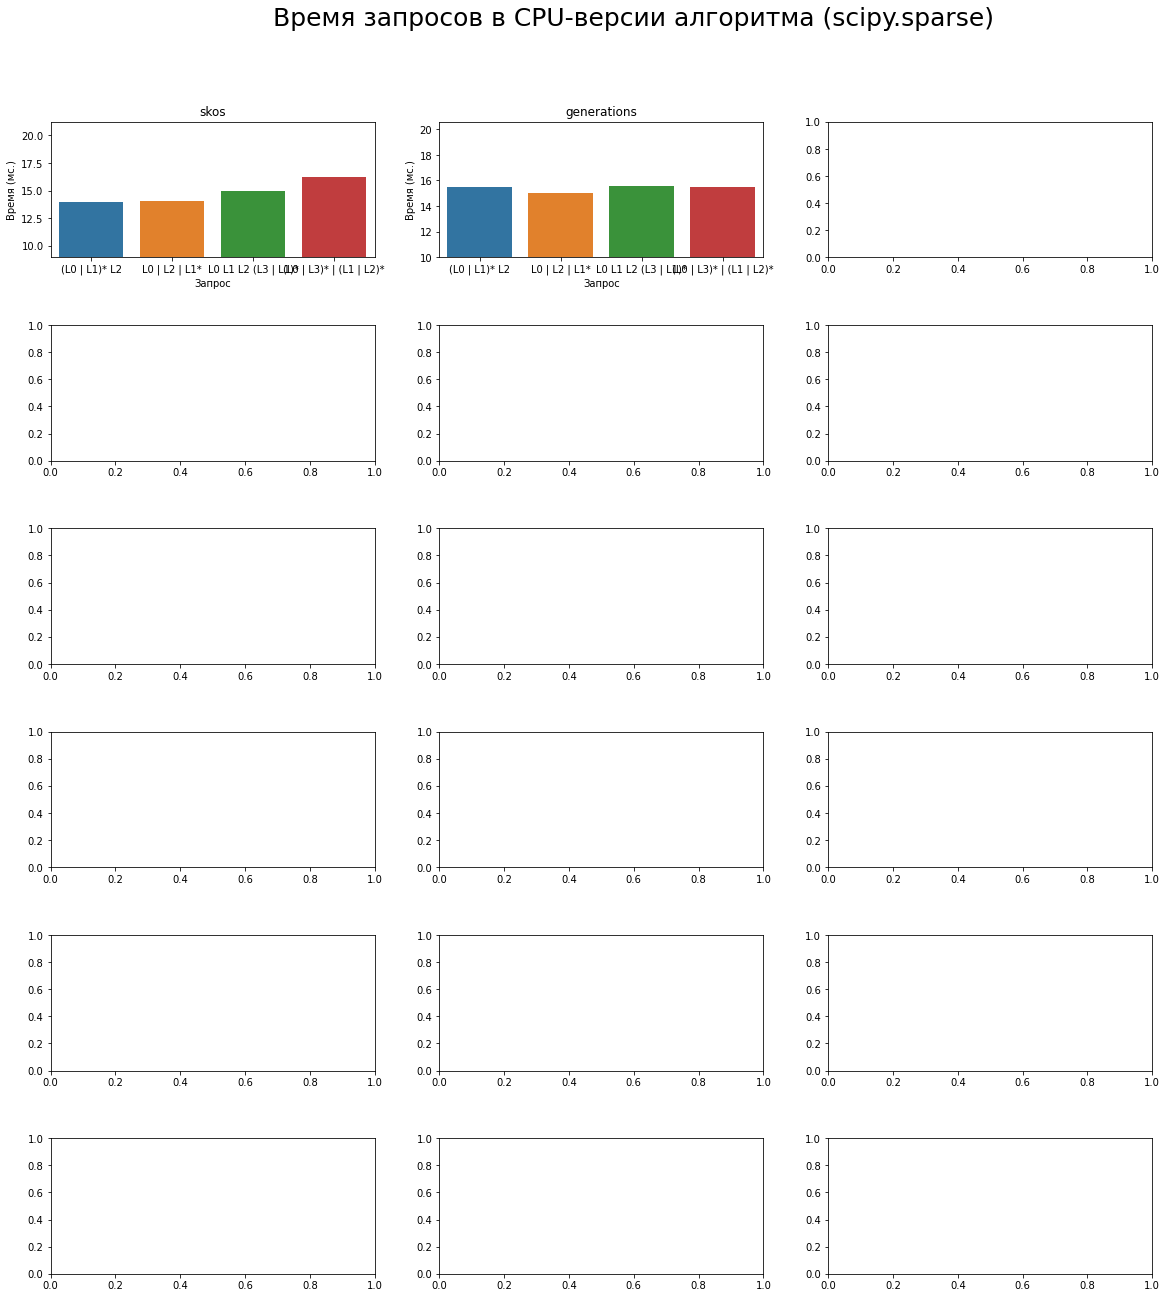

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Время запросов в СPU-версии алгоритма (scipy.sparse)', fontsize=25)

for i, graph in enumerate(GRAPHS):
    name = graph.description.name
    ax = sns.barplot(ax=axes[i // 3, i % 3], data=cpu_times_df, x=cpu_times_df.index, y=name)
    ax.set_title(name)
    
    delta = 5
    if name == "enzyme":
        delta = 700
    elif name in ["go_hierarchy", "eclass_514en", "go", "geospecies"]:
        delta = 10000

    min_lim = cpu_times_df[name].min() - delta
    max_lim = cpu_times_df[name].max() + delta
    
    ax.set(title=name, ylabel="Время (мс.)", xlabel="Запрос", ylim=(min_lim, max_lim))

plt.show()

### Производительность GPU-версии алгоритма ($pyCuBool$)

In [17]:
print("=== VERSION BASED ON GPU (pyCuBool) ===")

gpu_times_df = pd.DataFrame(index=queries, columns=GRAPH_NAMES)

for graph in GRAPHS:
    labels = list(graph.description.edge_labels)

    for index, query_generator in enumerate(QUERIES):
        query = query_generator(labels)

        print(str(graph))
        print(f"Query: {query_generator.__doc__}")
        print("Perfomance:")
        results = tuple()
        time = None
        if graph.description.name not in ["enzyme", "go_hierarchy", "eclass_514en", "go", "geospecies"]:
            time = %timeit -n 1 -r 3 -o result = regular_path_querying(graph.graph, query, results, mode="gpu")
        else:
            time = %timeit -n 1 -r 1 -o result = regular_path_querying(graph.graph, query, results, mode="gpu")
        print("=== === ===")

        gpu_times_df.loc[queries[index], graph.description.name] = round(time.best * 1000, 2)


=== VERSION BASED ON GPU (pyCuBool) ===
Graph skos:
- number of nodes: 144
	- number of edges: 252
	- edge labels: {rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#comment'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#domain'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#isDefinedBy'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://purl.org/dc/terms/description'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#rest'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#unionOf'), rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#definition'), rdflib.term.URIRef('http://purl.org/dc/terms/contributor'), rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#example'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#seeAlso'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subPropertyOf'), rdflib.te

В таблице ниже показано время работы данной версии алгоритма (в **мс**.) в зависимости от графа и регулярного выражения.

In [18]:
gpu_times_df.to_csv("gpu_times.csv")

gpu_times_df

,skos,generations
(L0 | L1)* L2,15.25,17.41
L0 | L2 | L1*,13.16,16.62
L0 L1 L2 (L3 | L1)*,13.63,15.34
(L0 | L3)* | (L1 | L2)*,17.26,13.9


### Время каждого запроса в GPU-версии алгоритма ($pyCuBool$)

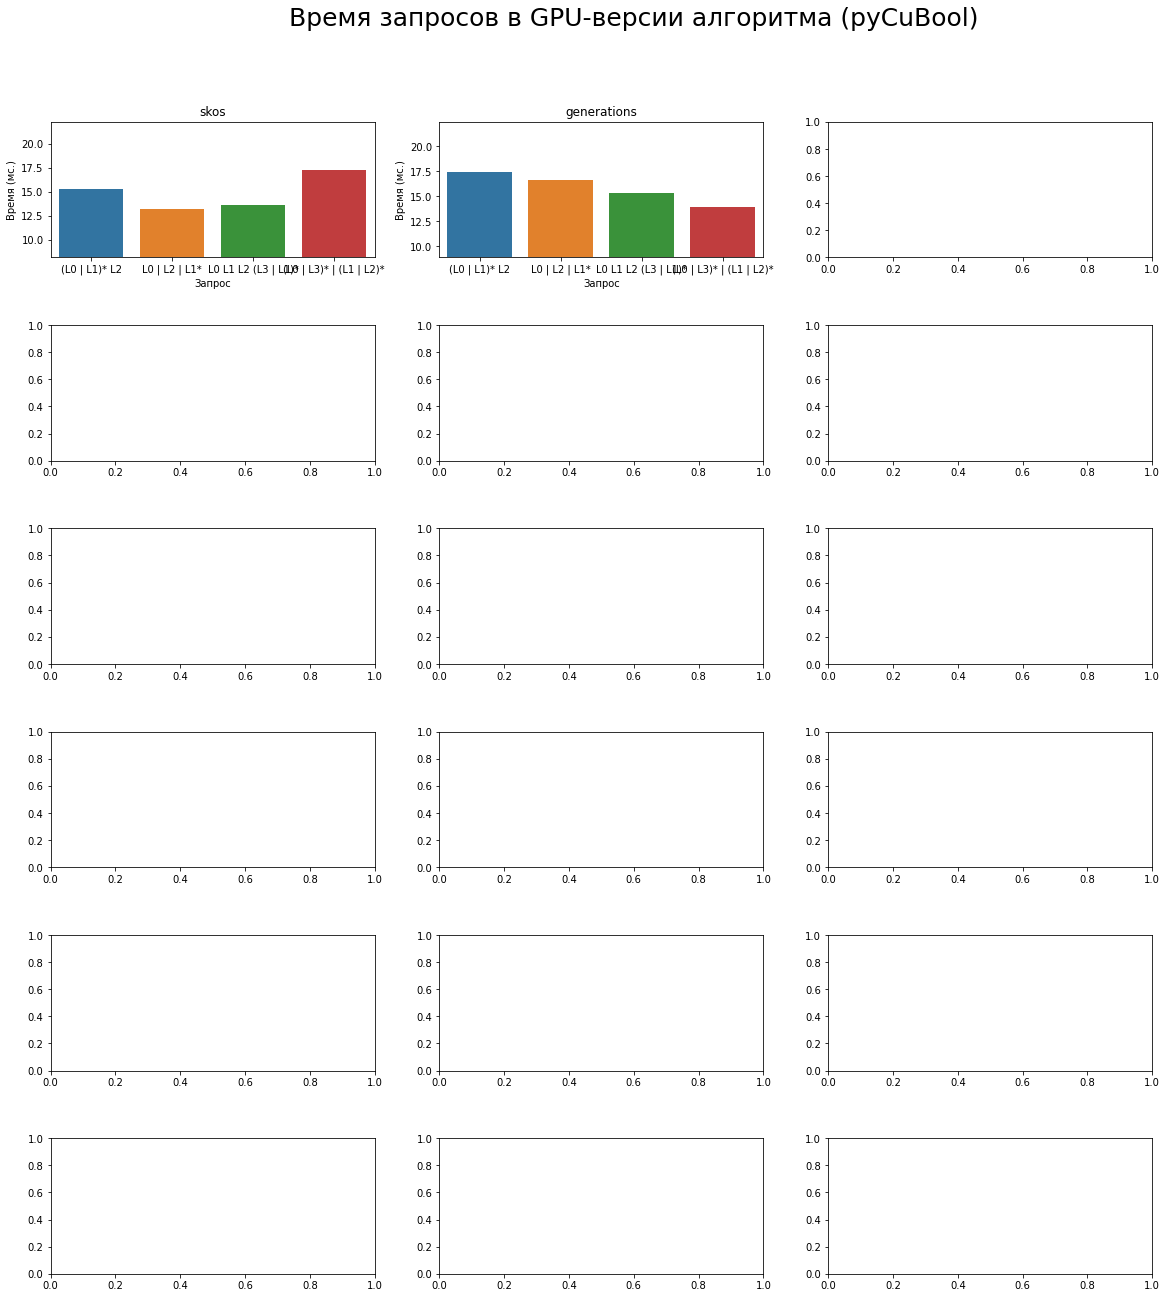

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Время запросов в GPU-версии алгоритма (pyCuBool)', fontsize=25)

for i, graph in enumerate(GRAPHS):
    name = graph.description.name
    ax = sns.barplot(ax=axes[i // 3, i % 3], data=gpu_times_df, x=gpu_times_df.index, y=name)
    ax.set_title(name)
    
    delta = 5
    if name == "enzyme":
        delta = 700
    elif name in ["go_hierarchy", "eclass_514en", "go", "geospecies"]:
        delta = 10000

    min_lim = gpu_times_df[name].min() - delta
    max_lim = gpu_times_df[name].max() + delta
    
    ax.set(title=name, ylabel="Время (мс.)", xlabel="Запрос", ylim=(min_lim, max_lim))

plt.show()

### Сравнение времени работы $CPU$-версии ($scipy.sparse$) и $GPU$-версии ($pyCuBool$) алгоритма

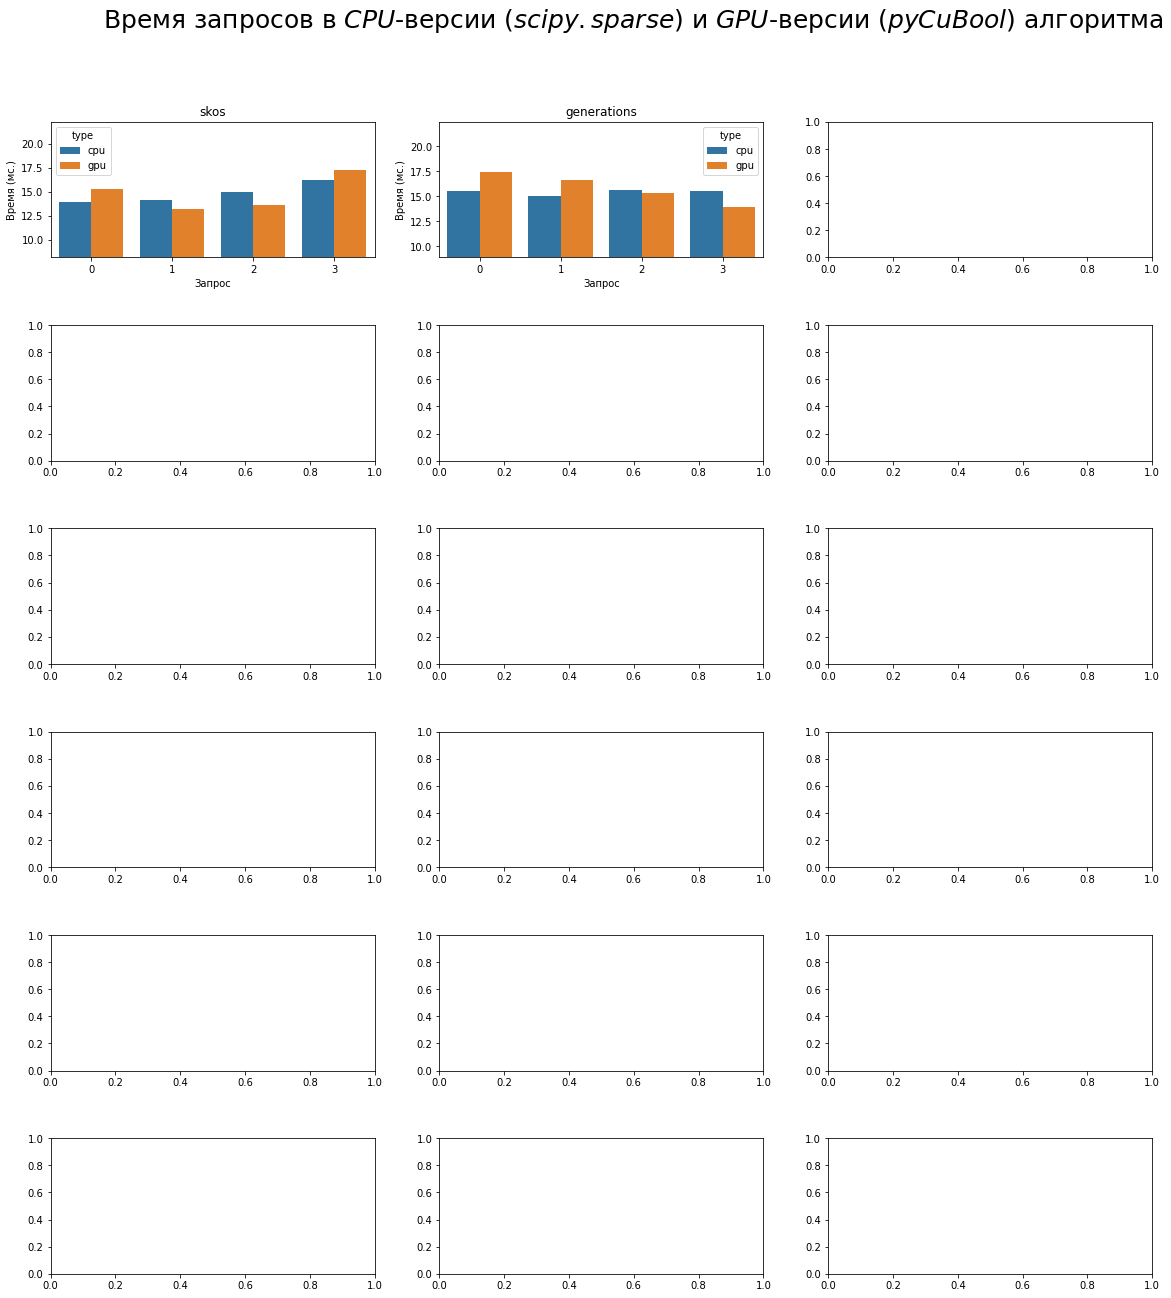

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig, axes = plt.subplots(6, 3, figsize=(18, 20))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig.suptitle('Время запросов в $CPU$-версии ($scipy.sparse$) и $GPU$-версии ($pyCuBool$) алгоритма', fontsize=25)

for i, graph in enumerate(GRAPHS):
    name = graph.description.name
    cpu_time = cpu_times_df[name]
    gpu_time = gpu_times_df[name]

    all_times_df = pd.DataFrame(pd.concat([cpu_time, gpu_time], ignore_index=True))
    all_times_df['type'] = pd.Series(["cpu", "cpu", "cpu", "cpu", "gpu", "gpu", "gpu", "gpu"])

    ax = sns.barplot(ax=axes[i // 3, i % 3], data=all_times_df, x=all_times_df.index % 4, y=name, hue="type")

    delta = 5
    if name == "enzyme":
        delta = 700
    elif name in ["go_hierarchy", "eclass_514en", "go", "geospecies"]:
        delta = 10000

    min_lim = gpu_times_df[name].min() - delta
    max_lim = gpu_times_df[name].max() + delta
    
    ax.set(title=name, ylabel="Время (мс.)", xlabel="Запрос", ylim=(min_lim, max_lim))

plt.show()


## Итоги исследования

Алгоритм решения проблемы $RPQ$ показал лучшие результаты в случае использования реализации с применением $pyCuBool$ для выполнения операций с булевыми матрицами. Данный результат объясняется тем, что библиотека $pyCuBool$ в своей реализации применяет технологию $NVIDIA$ $CUDA$, использующую графический ускоритель для вычислений. По данным эксперимента можно судить об эффективности параллельных вычислений при помощи данной технологии.